<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir data
!gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
!gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
!unzip -o -q test.zip -d data
!unzip -o -q train.zip -d data

!git clone https://github.com/Mamiglia/challenge.git

mkdir: cannot create directory ‘data’: File exists
Downloading...
From: https://drive.google.com/uc?id=1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
To: /content/test.zip
100% 5.80M/5.80M [00:00<00:00, 261MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
From (redirected): https://drive.google.com/uc?id=1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe&confirm=t&uuid=c2eade2d-3ba6-429a-9e6c-fd0f310c24b0
To: /content/train.zip
100% 4.07G/4.07G [00:17<00:00, 232MB/s]
fatal: destination path 'challenge' already exists and is not an empty directory.


In [ ]:
!pip install optuna

In [ ]:
import logging
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from rich.logging import RichHandler
from rich.progress import (BarColumn, MofNCompleteColumn, Progress, TextColumn,
                           TimeElapsedColumn, TimeRemainingColumn)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# 1. Setup the logger to use RichHandler
# This will also log to a file "training.log"
logging.basicConfig(
    level="INFO",
    format="%(message)s",
    datefmt="[%X]",
    handlers=[
        RichHandler(rich_tracebacks=True, show_path=False, markup=True),
        logging.FileHandler("training.log")
    ]
)

# 2. Get the logger instance
logger = logging.getLogger("rich")
logger.info("Logging setup complete. Logs will go to terminal and 'training.log'.")

# 3. Define a helper function to create our custom progress bar
def get_rich_progress_bar():
    """Returns a Rich Progress bar instance."""
    return Progress(
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        MofNCompleteColumn(),
        TimeRemainingColumn(),
        TimeElapsedColumn(),
        # This is a custom field we will update
        TextColumn("[[yellow]Loss: {task.fields[loss]:.4f}[/yellow]]"),
    )

# Custom functions from the repo
from challenge.src.common import generate_submission, load_data, prepare_train_data
from challenge.src.eval import visualize_retrieval

# Configuration
EPOCHS = 3 # Max epochs for Optuna trials
FINAL_EPOCHS = 100 # More epochs for the final model
MODEL_PATH = "models/mlp_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



SCHEDULER_PATIENCE = 5
EARLY_STOPPING_PATIENCE = 12
DEFAULT_BATCH_SIZE = 2048

# These are fixed from our dataset
INPUT_DIM = 1024  # RoBERTa
OUTPUT_DIM = 1536 # DINOv2

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# 1. Load data
train_data = load_data("data/train/train.npz")

# 2. Get unique image info *before* creating pairs
all_image_names = train_data['images/names']
n_images = len(all_image_names)
label_matrix = torch.from_numpy(train_data['captions/label']).bool() # [N_captions, N_images]

# 3. Create a random split of IMAGE indices
n_train_images = int(0.9 * n_images)
indices = torch.randperm(n_images)
train_image_indices = indices[:n_train_images]
val_image_indices = indices[n_train_images:]

# 4. Create masks for which images are in which set
train_image_mask = torch.zeros(n_images, dtype=torch.bool)
train_image_mask[train_image_indices] = True
val_image_mask = torch.zeros(n_images, dtype=torch.bool)
val_image_mask[val_image_indices] = True

# 5. Find which CAPTIONS map to which set of images
train_caption_mask = label_matrix[:, train_image_mask].any(dim=1)
val_caption_mask = label_matrix[:, val_image_mask].any(dim=1)

# 6. Now prepare the full X, y data
X, y, _ = prepare_train_data(train_data)

# 7. Apply the LEAK-FREE masks
X_train, X_val = X[train_caption_mask], X[val_caption_mask]
y_train, y_val = y[train_caption_mask], y[val_caption_mask]

print(f"Total Images: {n_images}")
print(f"Train Images: {n_train_images} | Val Images: {n_images - n_train_images}")
print(f"Total Captions: {len(X)}")
print(f"Train Captions: {len(X_train)} | Val Captions: {len(X_val)}")
# --- End of fix ---

DEFAULT_BATCH_SIZE = 2048
K_HARD_NEGATIVES = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

(125000,)
Train data: 125000 captions, 125000 images
Total Images: 25000
Train Images: 22500 | Val Images: 2500
Total Captions: 125000
Train Captions: 112500 | Val Captions: 12500


In [ ]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536,
                 d_model=512, nhead=8, nlayers=3, dim_feedforward=2048,
                 dropout_rate=0.3):
        """
        A Transformer Encoder-based model to map embeddings, using a [CLS] token.

        Args:
            input_dim (int): Dimension of the input embedding (e.g., 1024 for RoBERTa)
            output_dim (int): Dimension of the target embedding (e.g., 1536 for DINOv2)
            d_model (int): The "hidden size" of the Transformer. Must be divisible by nhead.
            nhead (int): The number of attention heads.
            nlayers (int): The number of stacked Transformer Encoder layers.
            dim_feedforward (int): The dimension of the feed-forward network in the encoder.
            dropout_rate (float): The dropout rate to use.
        """
        super().__init__()
        self.d_model = d_model

        # 1. Input projection: Project RoBERTa dim (1024) to the Transformer's d_model
        self.input_proj = nn.Linear(input_dim, d_model)

        # 2. Learnable [CLS] token
        # This will be prepended to the sequence.
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model)) # (Batch, Seq, Dim)

        # 3. Learnable positional embedding
        # We now have a sequence of length 2: ([CLS], input_token)
        self.pos_embed = nn.Parameter(torch.zeros(1, 2, d_model)) # (Batch, Seq_len, Dim)

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_rate,
            activation="gelu",
            batch_first=True # Ensures input shape is (Batch, Seq, Dim)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=nlayers
        )

        # 5. Output head
        # Takes the Transformer's output and projects it to DINOv2 dim (1536)
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x shape: (Batch, input_dim)

        # 1. Project input to d_model
        x = self.input_proj(x)
        # x shape: (Batch, d_model)

        # 2. Add "sequence" dimension -> (Batch, 1, d_model)
        x = x.unsqueeze(1)

        # 3. Prepare [CLS] token
        # Get batch size from x
        batch_size = x.size(0)
        # Expand [CLS] token to match batch size -> (Batch, 1, d_model)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # 4. Prepend [CLS] token to the input sequence
        # x shape: (Batch, 2, d_model)
        x = torch.cat([cls_tokens, x], dim=1)

        # 5. Add positional embedding (uses broadcasting)
        x = x + self.pos_embed

        # 6. Pass through transformer
        # x shape: (Batch, 2, d_model)
        x = self.transformer_encoder(x)

        # 7. Get the output of the [CLS] token (the first token)
        # x shape: (Batch, d_model)
        x = x[:, 0, :]

        # 8. Normalize and project to final output dimension
        x = self.norm(x)
        x = self.output_head(x)
        # x shape: (Batch, output_dim)

        return x

In [ ]:
# Modified loss function (calculates loss from a given similarity matrix)
def k_hard_loss_from_sim(sim_matrix, temp, k, device):
    """Calculates InfoNCE with K-Hard Negatives from a similarity matrix."""

    # sim_matrix is assumed to be (pred_embs @ true_embs.T) * temp
    b = sim_matrix.size(0)

    # 1. Get positive similarities (the diagonal)
    pos_sim = sim_matrix.diag().clone().unsqueeze(1) # Shape: (B, 1)

    # 2. Get negative similarities
    neg_sim_matrix = sim_matrix.clone()
    neg_sim_matrix.fill_diagonal_(float('-inf'))

    # 3. Find the K hardest negatives
    safe_k = min(k, b - 2)
    if safe_k <= 0:
        labels = torch.arange(b).to(device)
        return F.cross_entropy(sim_matrix, labels)

    hard_k_neg_sims, _ = torch.topk(neg_sim_matrix, k=safe_k, dim=1) # Shape: (B, K)

    # 4. Create new logits and labels
    logits = torch.cat([pos_sim, hard_k_neg_sims], dim=1) # Shape: (B, K+1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)

    # 5. Calculate loss
    loss = F.cross_entropy(logits, labels)
    return loss

# New symmetric loss function
def symmetric_k_hard_loss(predicted_embs, true_image_embs, temp, k, device):
    """
    Calculates the SYMMETRIC InfoNCE loss with K-Hard Negative Mining.
    This version is optimized to compute the similarity matrix only once.
    """

    # Normalize embeddings
    pred_embs = F.normalize(predicted_embs, p=2, dim=1)
    true_embs = F.normalize(true_image_embs, p=2, dim=1)

    # Calculate all-pairs similarity matrix ONCE
    sim_matrix_t2i = (pred_embs @ true_embs.T) * temp

    # 1. Caption-to-Image Loss (t2i)
    loss_t2i = k_hard_loss_from_sim(sim_matrix_t2i, temp, k, device)

    # 2. Image-to-Caption Loss (i2t)
    # Just transpose the matrix! No new multiplication.
    sim_matrix_i2t = sim_matrix_t2i.T
    loss_i2t = k_hard_loss_from_sim(sim_matrix_i2t, temp, k, device)

    # 3. Total Loss
    loss = (loss_t2i + loss_i2t) / 2
    return loss

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import numpy as np
import optuna

# Assuming the following are defined globally (as in your notebook):
# EPOCHS, DEVICE, INPUT_DIM, OUTPUT_DIM,
# TransformerModel, symmetric_k_hard_loss

def run_training_trial(trial, params, train_dataset, val_dataset):
    """
    Train a model for one Optuna trial.
    Accepts a dict of parameters AND the trial object.
    Returns the best validation MRR.
    """

    # Create DataLoaders with the suggested batch size
    batch_size = params["batch_size"]
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    # --- NEW: Define scheduler steps ---
    # Assumes EPOCHS is a global constant (e.g., EPOCHS = 10)
    WARMUP_STEPS = len(train_loader) # Warmup for 1 epoch
    TOTAL_STEPS = len(train_loader) * EPOCHS

    # Define TransformerModel from params
    model = TransformerModel(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        d_model=params["d_model"],
        nhead=params["nhead"],
        nlayers=params["nlayers"],
        dim_feedforward=params["dim_feedforward"],
        dropout_rate=params["dropout_rate"]
    ).to(DEVICE)

    # --- CHANGE: Use AdamW ---
    optimizer = optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"]
    )

    # --- NEW: Initialize Scheduler ---
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=TOTAL_STEPS - WARMUP_STEPS, # Steps *after* warmup
        eta_min=1e-7                      # Minimum LR
    )

    best_val_mrr = 0.0

    # Assumes EARLY_STOPPING_PATIENCE is defined in your config cell (cell 2)
    early_stopping_patience = 12
    patience_counter = 0

    temp = params["temperature"]
    alpha = params["mixup_alpha"]
    noise_std = params["noise_std"]
    k = params["k_hard_negatives"] # Use k from params

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS): # Use global EPOCHS
        # Training
        model.train()
        train_loss = 0

        # --- MODIFICATION: Added 'i' for step counting ---
        for i, (X_batch, y_batch) in enumerate(train_loader): # No tqdm
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            # --- NEW: LR Scheduler & Warmup Logic ---
            current_step = epoch * len(train_loader) + i
            if current_step < WARMUP_STEPS:
                # Linear Warmup
                lr_scale = float(current_step + 1) / float(WARMUP_STEPS)
                for param_group in optimizer.param_groups:
                    # Use the *target* LR from params
                    param_group['lr'] = params["lr"] * lr_scale
            else:
                # Cosine Decay
                scheduler.step()
            # ----------------------------------------

            # --- NEW: Add Gaussian Noise ---
            if noise_std > 0:
                X_batch = X_batch + (torch.randn_like(X_batch) * noise_std)
            # ------------------------------

            # Mixup
            lam = np.random.beta(alpha, alpha)
            indices = torch.randperm(X_batch.size(0)).to(DEVICE)
            X_2, y_2 = X_batch[indices], y_batch[indices]
            X_batch_mixed = lam * X_batch + (1.0 - lam) * X_2
            y_batch_mixed = lam * y_batch + (1.0 - lam) * y_2

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                predicted_embs = model(X_batch_mixed)
                true_image_embs = y_batch_mixed

                # --- FIX: Use 'k' from params ---
                loss = symmetric_k_hard_loss(
                    predicted_embs, true_image_embs, temp, k, DEVICE
                )

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        all_reciprocal_ranks = []
        all_ranks = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

                with torch.cuda.amp.autocast():
                    predicted_embs = model(X_batch)
                    true_image_embs = y_batch

                    predicted_embs = F.normalize(predicted_embs, p=2, dim=1)
                    true_image_embs = F.normalize(true_image_embs, p=2, dim=1)

                    # --- NOTE: Using 'temp' from params here ---
                    sim_matrix = (predicted_embs @ true_image_embs.T) * temp
                    labels = torch.arange(X_batch.size(0)).to(DEVICE)

                    loss = F.cross_entropy(sim_matrix, labels)

                val_loss += loss.item()

                correct_scores = sim_matrix.diag().unsqueeze(1) + 1e-6
                ranks = (sim_matrix > correct_scores).sum(dim=1) + 1
                all_ranks.append(ranks)
                all_reciprocal_ranks.append(1.0 / ranks.float())

        val_loss /= len(val_loader)

        all_ranks = torch.cat(all_ranks)
        all_reciprocal_ranks = torch.cat(all_reciprocal_ranks)
        mrr = all_reciprocal_ranks.mean().item()

        trial.report(mrr, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # --- REMOVED ---
        # scheduler.step(mrr) # This is not needed for CosineAnnealingLR
        # -----------------

        if mrr > best_val_mrr:
            best_val_mrr = mrr
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                break

    return best_val_mrr

In [ ]:
def train_model_final(params, train_dataset, val_dataset, device, epochs):
    """
    Trains the FINAL model using the best parameters and saves it.
    Uses Rich for logging and progress bars.
    """
    logger.info("Training final model with best parameters...")
    logger.info(f"Params: {params}") # Log the parameters

    batch_size = params["batch_size"]
    logger.info(f"Using final batch size: {batch_size}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    # --- NEW: Use the 'epochs' parameter passed to the function ---
    WARMUP_STEPS = len(train_loader) # Warmup for 1 epoch
    TOTAL_STEPS = len(train_loader) * epochs # Use 'epochs' variable

    dim_feedforward = params["d_model"] * params["ff_multiplier"]

    model = TransformerModel(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        d_model=params["d_model"],
        nhead=params["nhead"],
        nlayers=params["nlayers"],
        dim_feedforward=dim_feedforward, # Use the calculated value
        dropout_rate=params["dropout_rate"]
    ).to(device)

    # --- CHANGE: Use AdamW ---
    optimizer = optim.AdamW(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"]
    )

    # --- NEW: Initialize Scheduler ---
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=TOTAL_STEPS - WARMUP_STEPS, # Steps *after* warmup
        eta_min=1e-7                      # Minimum LR
    )

    best_mrr = 0.0 # Track best MRR
    early_stopping_patience = 12
    patience_counter = 0

    temp = params["temperature"]
    alpha = params["mixup_alpha"]
    noise_std = params["noise_std"]

    if noise_std > 0:
        logger.info(f"Applying Gaussian noise with std: {noise_std:.4f}")

    k = params["k_hard_negatives"] # Use k from params
    logger.info(f"Using K-Hard Negatives: {k}")

    history = []
    best_val_ranks = None

    scaler = torch.cuda.amp.GradScaler()

    # --- RICH PROGRESS BAR SETUP --
    with get_rich_progress_bar() as progress:
        epoch_task = progress.add_task("[cyan]Epochs", total=epochs, loss=0.0)

        for epoch in range(epochs):
            # --- TRAINING --
            model.train()
            train_loss = 0
            train_task = progress.add_task("[green]   Training", total=len(train_loader), loss=0.0)

            # --- MODIFICATION: Added 'i' for step counting ---
            for i, (X_batch, y_batch) in enumerate(train_loader):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # --- NEW: LR Scheduler & Warmup Logic ---
                current_step = epoch * len(train_loader) + i
                if current_step < WARMUP_STEPS:
                    # Linear Warmup
                    lr_scale = float(current_step + 1) / float(WARMUP_STEPS)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = params["lr"] * lr_scale
                else:
                    # Cosine Decay
                    scheduler.step()
                # ----------------------------------------

                if noise_std > 0:
                    X_batch = X_batch + (torch.randn_like(X_batch) * noise_std)

                lam = np.random.beta(alpha, alpha)
                indices = torch.randperm(X_batch.size(0)).to(device)
                X_2, y_2 = X_batch[indices], y_batch[indices]
                X_batch_mixed = lam * X_batch + (1.0 - lam) * X_2
                y_batch_mixed = lam * y_batch + (1.0 - lam) * y_2

                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    predicted_embs = model(X_batch_mixed)
                    true_image_embs = y_batch_mixed

                    # --- FIX: Use 'k' from params ---
                    loss = symmetric_k_hard_loss(
                        predicted_embs, true_image_embs, temp, k, device
                    )

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()

                progress.update(train_task, advance=1, fields={"loss": loss.item()})

            train_loss /= len(train_loader)
            progress.remove_task(train_task)

            # --- VALIDATION ---
            model.eval()
            val_loss = 0
            all_reciprocal_ranks = []
            all_ranks = []
            val_task = progress.add_task("[blue]   Validating", total=len(val_loader), loss=0.0)

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                    with torch.cuda.amp.autocast():
                        predicted_embs = model(X_batch)
                        true_image_embs = y_batch

                        predicted_embs = F.normalize(predicted_embs, p=2, dim=1)
                        true_image_embs = F.normalize(true_image_embs, p=2, dim=1)

                        sim_matrix = (predicted_embs @ true_image_embs.T) * temp
                        labels = torch.arange(X_batch.size(0)).to(DEVICE)

                        loss = F.cross_entropy(sim_matrix, labels)

                    val_loss += loss.item()

                    correct_scores = sim_matrix.diag().unsqueeze(1) + 1e-6
                    ranks = (sim_matrix > correct_scores).sum(dim=1) + 1
                    all_ranks.append(ranks)
                    all_reciprocal_ranks.append(1.0 / ranks.float())

                    progress.update(val_task, advance=1, fields={"loss": loss.item()})

            val_loss /= len(val_loader)
            progress.remove_task(val_task)

            # --- AGGREGATE AND LOG METRICS ---
            all_ranks = torch.cat(all_ranks)
            all_reciprocal_ranks = torch.cat(all_reciprocal_ranks)

            r1 = (all_ranks <= 1).float().mean().item()
            r5 = (all_ranks <= 5).float().mean().item()
            r10 = (all_ranks <= 10).float().mean().item()
            mrr = all_reciprocal_ranks.mean().item()

            current_lr = optimizer.param_groups[0]['lr']

            logger.info(
                f"Epoch {epoch+1:02d}: "
                f"LR=[cyan]{current_lr:.1e}[/] | "
                f"Train Loss=[green]{train_loss:.6f}[/] | "
                f"Val Loss=[blue]{val_loss:.6f}[/] | "
                f"[bold]MRR=[magenta]{mrr:.4f}[/bold]"
            )
            logger.info(
                f"   => Metrics: R@1={r1:.4f} | "
                f"R@5={r5:.4f} | "
                f"R@10={r10:.4f}"
            )

            history.append({
                "epoch": epoch + 1, "lr": current_lr, "train_loss": train_loss,
                "val_loss": val_loss, "R@1": r1, "R@5": r5, "R@10": r10, "MRR": mrr
            })

            # --- REMOVED ---
            # scheduler.step(mrr) # Not needed for CosineAnnealingLR
            # -----------------

            if mrr > best_mrr:
                best_mrr = mrr
                Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
                torch.save(model.state_dict(), MODEL_PATH)
                logger.info(f"   [bold green]✓ Saved best model (MRR={mrr:.6f})[/bold green]")
                patience_counter = 0
                best_val_ranks = all_ranks.cpu().numpy() # Save ranks
            else:
                patience_counter += 1
                logger.warning(f"   [yellow]! No improvement. Patience: {patience_counter}/{early_stopping_patience}[/yellow]")
                if patience_counter >= early_stopping_patience:
                    logger.warning(f"--- Early stopping triggered after {epoch + 1} epochs ---")
                    break

            progress.update(epoch_task, advance=1, fields={"loss": val_loss})

    logger.info(f"Training complete. Best model saved to {MODEL_PATH}")
    model.load_state_dict(torch.load(MODEL_PATH))
    return model, history, best_val_ranks

In [ ]:
def objective(trial):

    # --- Transformer Hyperparameters ---
    nhead = trial.suggest_categorical('nhead', [8, 16])
    d_model = trial.suggest_categorical('d_model', [768, 1024])
    # ----------------------------------------------------------------

    # --- Suggest a multiplier, not a dynamic value ---
    ff_multiplier = trial.suggest_categorical('ff_multiplier', [4, 6, 8])
    dim_feedforward = d_model * ff_multiplier

    nlayers = trial.suggest_int('nlayers', 1, 6)

    # --- MODIFICATION: Add k_hard_negatives ---
    k_hard_negatives = trial.suggest_categorical('k_hard_negatives', [128, 256, 512])

    params = {
        'lr': trial.suggest_float('lr', 1e-5, 5e-4, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),

        'nhead': nhead,
        'd_model': d_model,
        'nlayers': nlayers,
        'dim_feedforward': dim_feedforward,
        'noise_std': trial.suggest_float('noise_std', 0.0, 0.025),

        'dropout_rate': trial.suggest_float('dropout_rate', 0.3, 0.5),
        'temperature': trial.suggest_float('temperature', 28.0, 33.0),
        'mixup_alpha': trial.suggest_float('mixup_alpha', 0.4, 0.6),

        'batch_size': trial.suggest_categorical('batch_size', [8192]),

        # --- MODIFICATION: Pass k_hard_negatives to params ---
        'k_hard_negatives': k_hard_negatives
    }

    # 1. Pass the 'trial' object to the training function
    best_val_mrr = run_training_trial(trial, params, train_dataset, val_dataset)

    # 2. Return the score
    return best_val_mrr

In [ ]:
# print("Starting hyperparameter search...")
#
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
#
# print("\\nSearch complete!")
# print(f"Best validation MRR: {study.best_value:.6f}")
# print("Best parameters found:")
# print(study.best_params)
#
# best_params = study.best_params

In [ ]:
# Use the best parameters found by the study
# If you want to use the ones from your log, uncomment the line below
best_params =  {'nhead': 16, 'd_model': 1024, 'ff_multiplier': 4, 'nlayers': 1, 'k_hard_negatives': 128, 'lr': 0.00022732838492419994, 'weight_decay': 0.00014271358864438602, 'noise_std': 0.004940664964662731, 'dropout_rate': 0.4561339452133471, 'temperature': 29.191567155693587, 'mixup_alpha': 0.510962116079207, 'batch_size': 8192}
model, history, best_val_ranks = train_model_final(best_params, train_dataset, val_dataset, DEVICE, FINAL_EPOCHS)
# Save the history for later
history_df = pd.DataFrame(history)
history_df.to_csv("training_history.csv", index=False)
print("Training history saved to training_history.csv")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Output()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will 
create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller 
than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader 
running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

/tmp/ipython-input-2345139237.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 
`torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

/tmp/ipython-input-2345139237.py:143: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 
`torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Training history saved to training_history.csv


Plot saved to training_plot.png


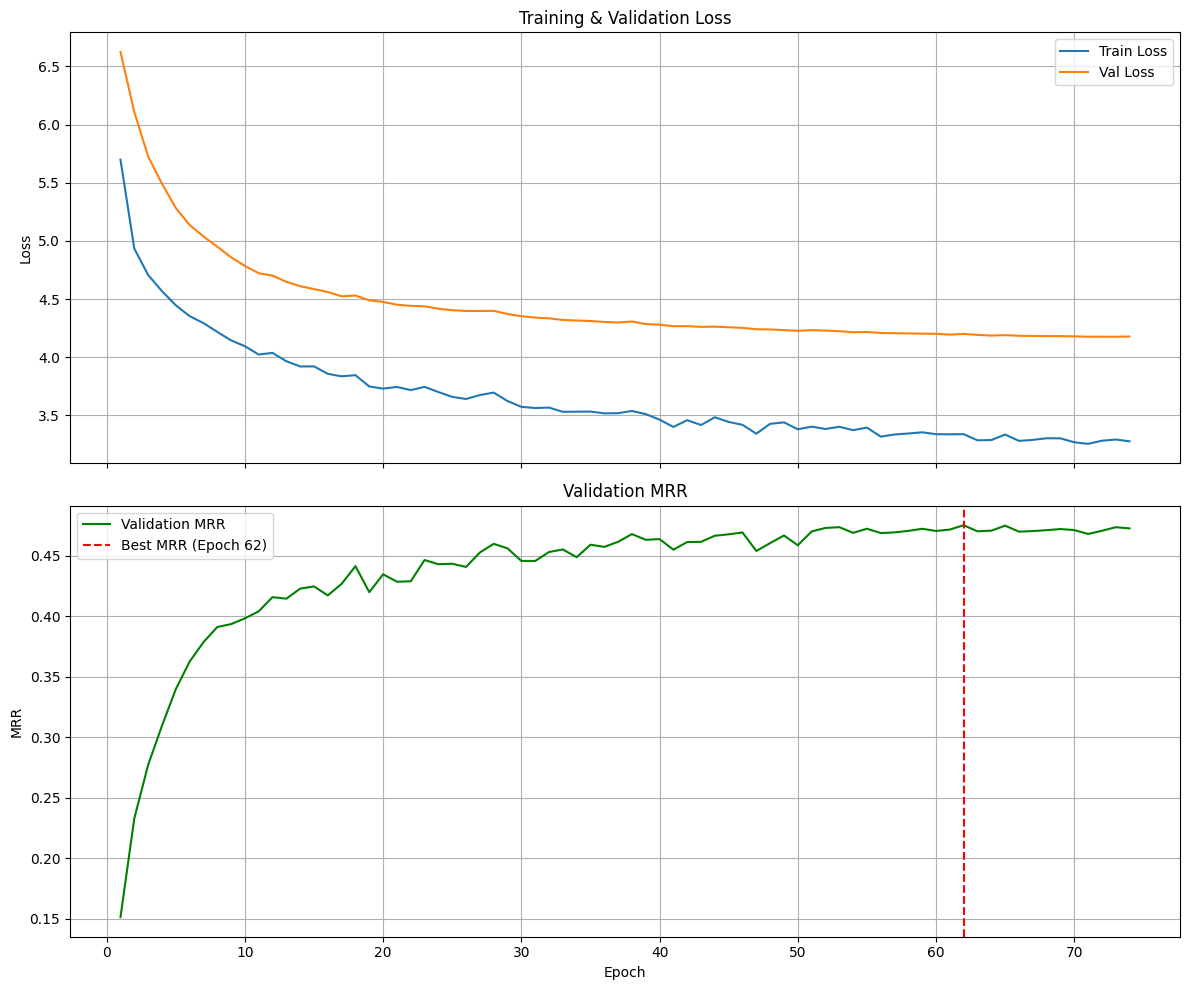

In [ ]:
import matplotlib.pyplot as plt

# Load the history
history_df = pd.read_csv("training_history.csv")

# Plot Losses and MRR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Losses
ax1.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
ax1.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)
ax1.set_title("Training & Validation Loss")

# Plot 2: MRR
ax2.plot(history_df['epoch'], history_df['MRR'], label='Validation MRR', color='green')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MRR")
ax2.legend()
ax2.grid(True)
ax2.set_title("Validation MRR")

# Find the best MRR epoch
best_mrr_epoch = history_df['MRR'].idxmax()
ax2.axvline(x=history_df.loc[best_mrr_epoch, 'epoch'], color='red', linestyle='--', label=f"Best MRR (Epoch {history_df.loc[best_mrr_epoch, 'epoch']})")
ax2.legend()

plt.tight_layout()
plt.savefig("training_plot.png")
print("Plot saved to training_plot.png")

In [ ]:
print("Running evaluation...")
model.eval()

# Get the correct validation image files and embeddings
val_img_files = train_data['images/names'][val_image_indices]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][val_image_indices]).to(DEVICE)

# Get the correct validation caption text
val_caption_text = train_data['captions/text'][val_caption_mask]

# Get the correct ground-truth mapping
# This is tricky: we need the index of the image *within the val_img_files*
val_label_matrix_full = train_data['captions/label'][val_caption_mask]
val_label_matrix_subset = val_label_matrix_full[:, val_image_indices]
# val_gt_indices[i] = index 'j' such that val_img_files[j] is the correct image for val_caption_text[i]
val_gt_indices = np.nonzero(val_label_matrix_subset)[1]


# Sample and visualize
for _ in range(5):
    idx = np.random.randint(0, len(X_val))

    caption_embd = X_val[idx]
    caption_text = val_caption_text[idx]
    gt_index_in_val_set = val_gt_indices[idx]

    with torch.no_grad():
        # Predict the image embedding from the caption
        pred_img_emb = model(caption_embd.to(DEVICE).unsqueeze(0)).cpu()

        # --- Corrected Metric: Cosine Similarity ---
        pred_img_emb_norm = F.normalize(pred_img_emb, p=2, dim=1)
        val_img_embd_norm = F.normalize(val_img_embd.cpu(), p=2, dim=1)

        # Find the most similar images
        similarities = pred_img_emb_norm @ val_img_embd_norm.T

        # Get top 5 scores and their indices
        top_k_scores, top_k_indices = torch.topk(similarities.squeeze(0), k=5)

        # ---

        print(f"\nCAPTION: \"{caption_text}\"")
        print(f"Ground Truth Image: {val_img_files[gt_index_in_val_set]}")
        print("--- Top 5 Predictions ---")
        for i in range(5):
            pred_idx = top_k_indices[i].item()
            score = top_k_scores[i].item()
            is_correct = "Correct!" if pred_idx == gt_index_in_val_set else ""
            print(f"  {i+1}. {val_img_files[pred_idx]} (Score: {score:.4f}) {is_correct}")

        # Note: The provided `visualize_retrieval` might be based on L2/MSE.
        # This manual printout uses the correct cosine similarity metric.
        # If you want to use `visualize_retrieval`, you'd need to adapt it.

        # To use the original visualizer (if it expects L2 distance):
        # We can pass the *predicted embedding* and let it calculate L2 distance,
        # but the model wasn't trained for that.

        visualize_retrieval(
            pred_img_emb, # The embedding, not scores
            gt_index_in_val_set,
            val_img_files,
            caption_text,
            val_img_embd.cpu(), # The true embeddings
            k=5
        )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Generating submission file...")

test_data = load_data("data/test/test.clean.npz")
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()

# Put model in eval mode
model.eval()

pred_embds_list = []
test_loader = DataLoader(test_embds, batch_size=512) # Use large batch for inference

with torch.no_grad():
    # Use the rich progress bar
    with get_rich_progress_bar() as progress:
        task = progress.add_task("[magenta]Predicting Test Set", total=len(test_loader), loss=0.0)
        for batch_embds in test_loader:
            pred_batch = model(batch_embds.to(DEVICE)).cpu()
            pred_embds_list.append(pred_batch)
            progress.update(task, advance=1)

pred_embds = torch.cat(pred_embds_list, dim=0)

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")
print("Done.")

Output()

Generating submission file...


Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_best.pth
Done.
